In [1]:
## import
import lamindb as ln
import scanpy as sc

from scprint import scPrint

from scdataloader.data import SimpleAnnDataset
from scdataloader import Preprocessor, Collator

from torch.utils.data import DataLoader

from scdataloader.utils import load_genes

import numpy as np
import anndata as ad
from scipy.sparse import csr_matrix
import pandas as pd

from scib_metrics.benchmark import Benchmarker

from lightning.pytorch import Trainer

%load_ext autoreload
%autoreload 2

import torch
torch.set_float32_matmul_precision('medium')


💡 lamindb instance: jkobject/scprint


2024-02-16 16:35:00,396:INFO - Created a temporary directory at /tmp/tmp16e1_bmo
2024-02-16 16:35:00,399:INFO - Writing /tmp/tmp16e1_bmo/_remote_module_non_scriptable.py
2024-02-16 16:35:00,399:INFO - Writing /tmp/tmp16e1_bmo/_remote_module_non_scriptable.py


## preparing the model

In [2]:
#model = scPrint.load_from_checkpoint('../../data/tensorboard/scprint_test/urxxwu28/checkpoints/epoch=0-step=20000.ckpt') #chocolate-surf-8
model = scPrint.load_from_checkpoint('../../data/logs/scprint_test/f4vao230/checkpoints/epoch=10-step=27500.ckpt') #effortless-night-21


FileNotFoundError: [Errno 2] No such file or directory: './data/temp/embeddings.parquet'

In [ ]:
ensembl = load_genes(['NCBITaxon:9606'])
ensembl['ensembl_gene_id'] = ensembl.index

## Loading the data

In [ ]:
adata.sc.read(
  only dataset dropped
)

In [ ]:
adata = sc.read(
    "data/pancreas_atlas.h5ad",
    backup_url="https://figshare.com/ndownloader/files/24539828",
)


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/specs/registry.py:249: OldFormatWarning: Element '/X' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/specs/registry.py:249: OldFormatWarning: Element '/X' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/specs/registry.py:249: OldFormatWarning: Element '/layers' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))
/home/ml4ig1/miniconda3/envs/scprint

In [19]:
#adata = sc.read(
#    "data/lung_atlas.h5ad",
#    backup_url="https://figshare.com/ndownloader/files/24539942",
#)

In [20]:
#adata = sc.read_h5ad('/home/ml4ig1/scprint/.lamindb/BljRloq1xjcxRNDpejzI.h5ad')

In [21]:
Preprocessor()(adata.copy())
# cannot preprocess (first of all not raw counts and also doesn't have standardized values)

ValueError: Data is not raw counts, please check layers, find raw data, or bypass with force_preprocess

In [12]:
# You need to use counts
adata.X = adata.layers['counts']
del adata.layers

In [13]:
# you need to have ensembl gene ids 
# # removing the other ones
var = adata.var.merge(ensembl.drop_duplicates('symbol').set_index('symbol', drop=False), left_index=True, right_index=True, how='inner').sort_values(by="ensembl_gene_id").set_index('ensembl_gene_id')
adata = adata[:, var['symbol']]
adata.var = var

# adding back the missing genes
unseen = set(ensembl.index) - set(adata.var.index)
# adding them to adata
emptyda = ad.AnnData(
    csr_matrix((adata.shape[0], len(unseen)), dtype=np.float32),
    var=pd.DataFrame(index=list(unseen)),
    obs=pd.DataFrame(index=adata.obs.index),
)
adata = ad.concat([adata, emptyda], axis=1, join="outer", merge="only")
# do a validation function
adata.uns["unseen_genes"] = list(unseen)
adata = adata[:, adata.var.sort_index().index]

# Add at least the organism you are working with
adata.obs['organism_ontology_term_id'] = "NCBITaxon:9606"
adata

AnnData object with n_obs × n_vars = 16382 × 70116
    obs: 'tech', 'celltype', 'size_factors', 'organism_ontology_term_id'
    var: 'symbol', 'ncbi_gene_id', 'biotype', 'description', 'synonyms', 'mt', 'ribo', 'hb', 'organism'
    uns: 'unseen_genes'

In [ ]:
adataset = SimpleAnnDataset(adata, obs_to_output=['organism_ontology_term_id'])
col = Collator(organisms=["NCBITaxon:9606",], valid_genes=model.genes, how="most expr", max_len=2000,add_zero_genes = 200 )#mdataset.encoder['organism_ontology_term_id'])
dataloader = DataLoader(adataset, collate_fn=col, batch_size=32, num_workers=2, shuffle=False)

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


In [28]:
adata

AnnData object with n_obs × n_vars = 16382 × 70116
    obs: 'tech', 'celltype', 'size_factors', 'organism_ontology_term_id', '_scvi_organism_ontology_term_id'
    var: 'symbol', 'ncbi_gene_id', 'biotype', 'description', 'synonyms', 'mt', 'ribo', 'hb', 'organism'
    uns: 'unseen_genes', '_scvi_uuid', '_scvi_manager_uuid'

In [29]:
from scdataloader import AnnDataCollator
from anndata.experimental import AnnLoader
dataloader = AnnLoader([adata], collate_fn=AnnDataCollator(max_len=5000, organisms=["NCBITaxon:9606",], org_to_id={'NCBITaxon:9606': 'NCBITaxon:9606'}, how="most expr", logp1=True), batch_size=32, num_workers=4)

In [15]:
#from scvi.data import AnnDataManager
#from scvi.data.fields import CategoricalObsField, LayerField
#from scvi.dataloaders import AnnDataLoader
#from scdataloader import SCVICollator

#anndata_fields = [
#    LayerField(registry_key="x", layer=None, is_count_data=True),
#    CategoricalObsField(registry_key="organism_ontology_term_id", attr_key="organism_ontology_term_id"),
#]
#adata_manager = AnnDataManager(fields=anndata_fields)
#adata_manager.register_fields(adata)
#dataloader = AnnDataLoader(adata_manager, collate_fn=SCVICollator(max_len=5000, organisms=["NCBITaxon:9606",], org_to_id={'NCBITaxon:9606': 0}, how="most expr", logp1=True), batch_size=32, num_workers=4)

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


In [8]:
for i in dataloader:
    print(i["x"].shape)
    break

torch.Size([32, 2200])



In [9]:
trainer = Trainer(precision=16)

INFO: Using 16bit Automatic Mixed Precision (AMP)
2024-02-08 18:26:57,080:INFO - Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
2024-02-08 18:26:57,103:INFO - GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
2024-02-08 18:26:57,106:INFO - TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
2024-02-08 18:26:57,109:INFO - IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
2024-02-08 18:26:57,111:INFO - HPU available: False, using: 0 HPUs
2024-02-08 18:26:57,080:INFO - Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
2024-02-08 18:26:57,103:INFO - GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
2024-02-08 18:26:57,106:INFO - TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
2024-02-08 18:26:57,109:INFO - IPU available: False, using: 0 IPUs
INFO:

In [14]:
model.labels, model.pred_embedding

(['cell_type_ontology_term_id',
  'disease_ontology_term_id',
  'assay_ontology_term_id',
  'self_reported_ethnicity_ontology_term_id',
  'sex_ontology_term_id',
  'organism_ontology_term_id'],
 None)

In [10]:
model.pred_embedding = [
    "cell_type_ontology_term_id",
    "disease_ontology_term_id",
    "self_reported_ethnicity_ontology_term_id",
    "sex_ontology_term_id",
]

In [20]:
adata.obs['tech'].value_counts()


inDrop3       3605
smartseq2     2394
celseq2       2285
inDrop1       1937
inDrop2       1724
smarter       1492
inDrop4       1303
celseq        1004
fluidigmc1     638
Name: tech, dtype: int64

In [21]:
adata.obs.celltype.value_counts()

alpha                 5493
beta                  4169
ductal                2142
acinar                1669
delta                 1055
gamma                  699
activated_stellate     464
endothelial            313
quiescent_stellate     193
macrophage              79
mast                    42
epsilon                 32
schwann                 25
t_cell                   7
Name: celltype, dtype: int64

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"):
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2024-02-08 18:08:04,881:INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 10016 × 128
    obs: 'pred_cell_type_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'leiden'
    uns: 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'
couldn't log to tensorboard
couldn't log to wandb


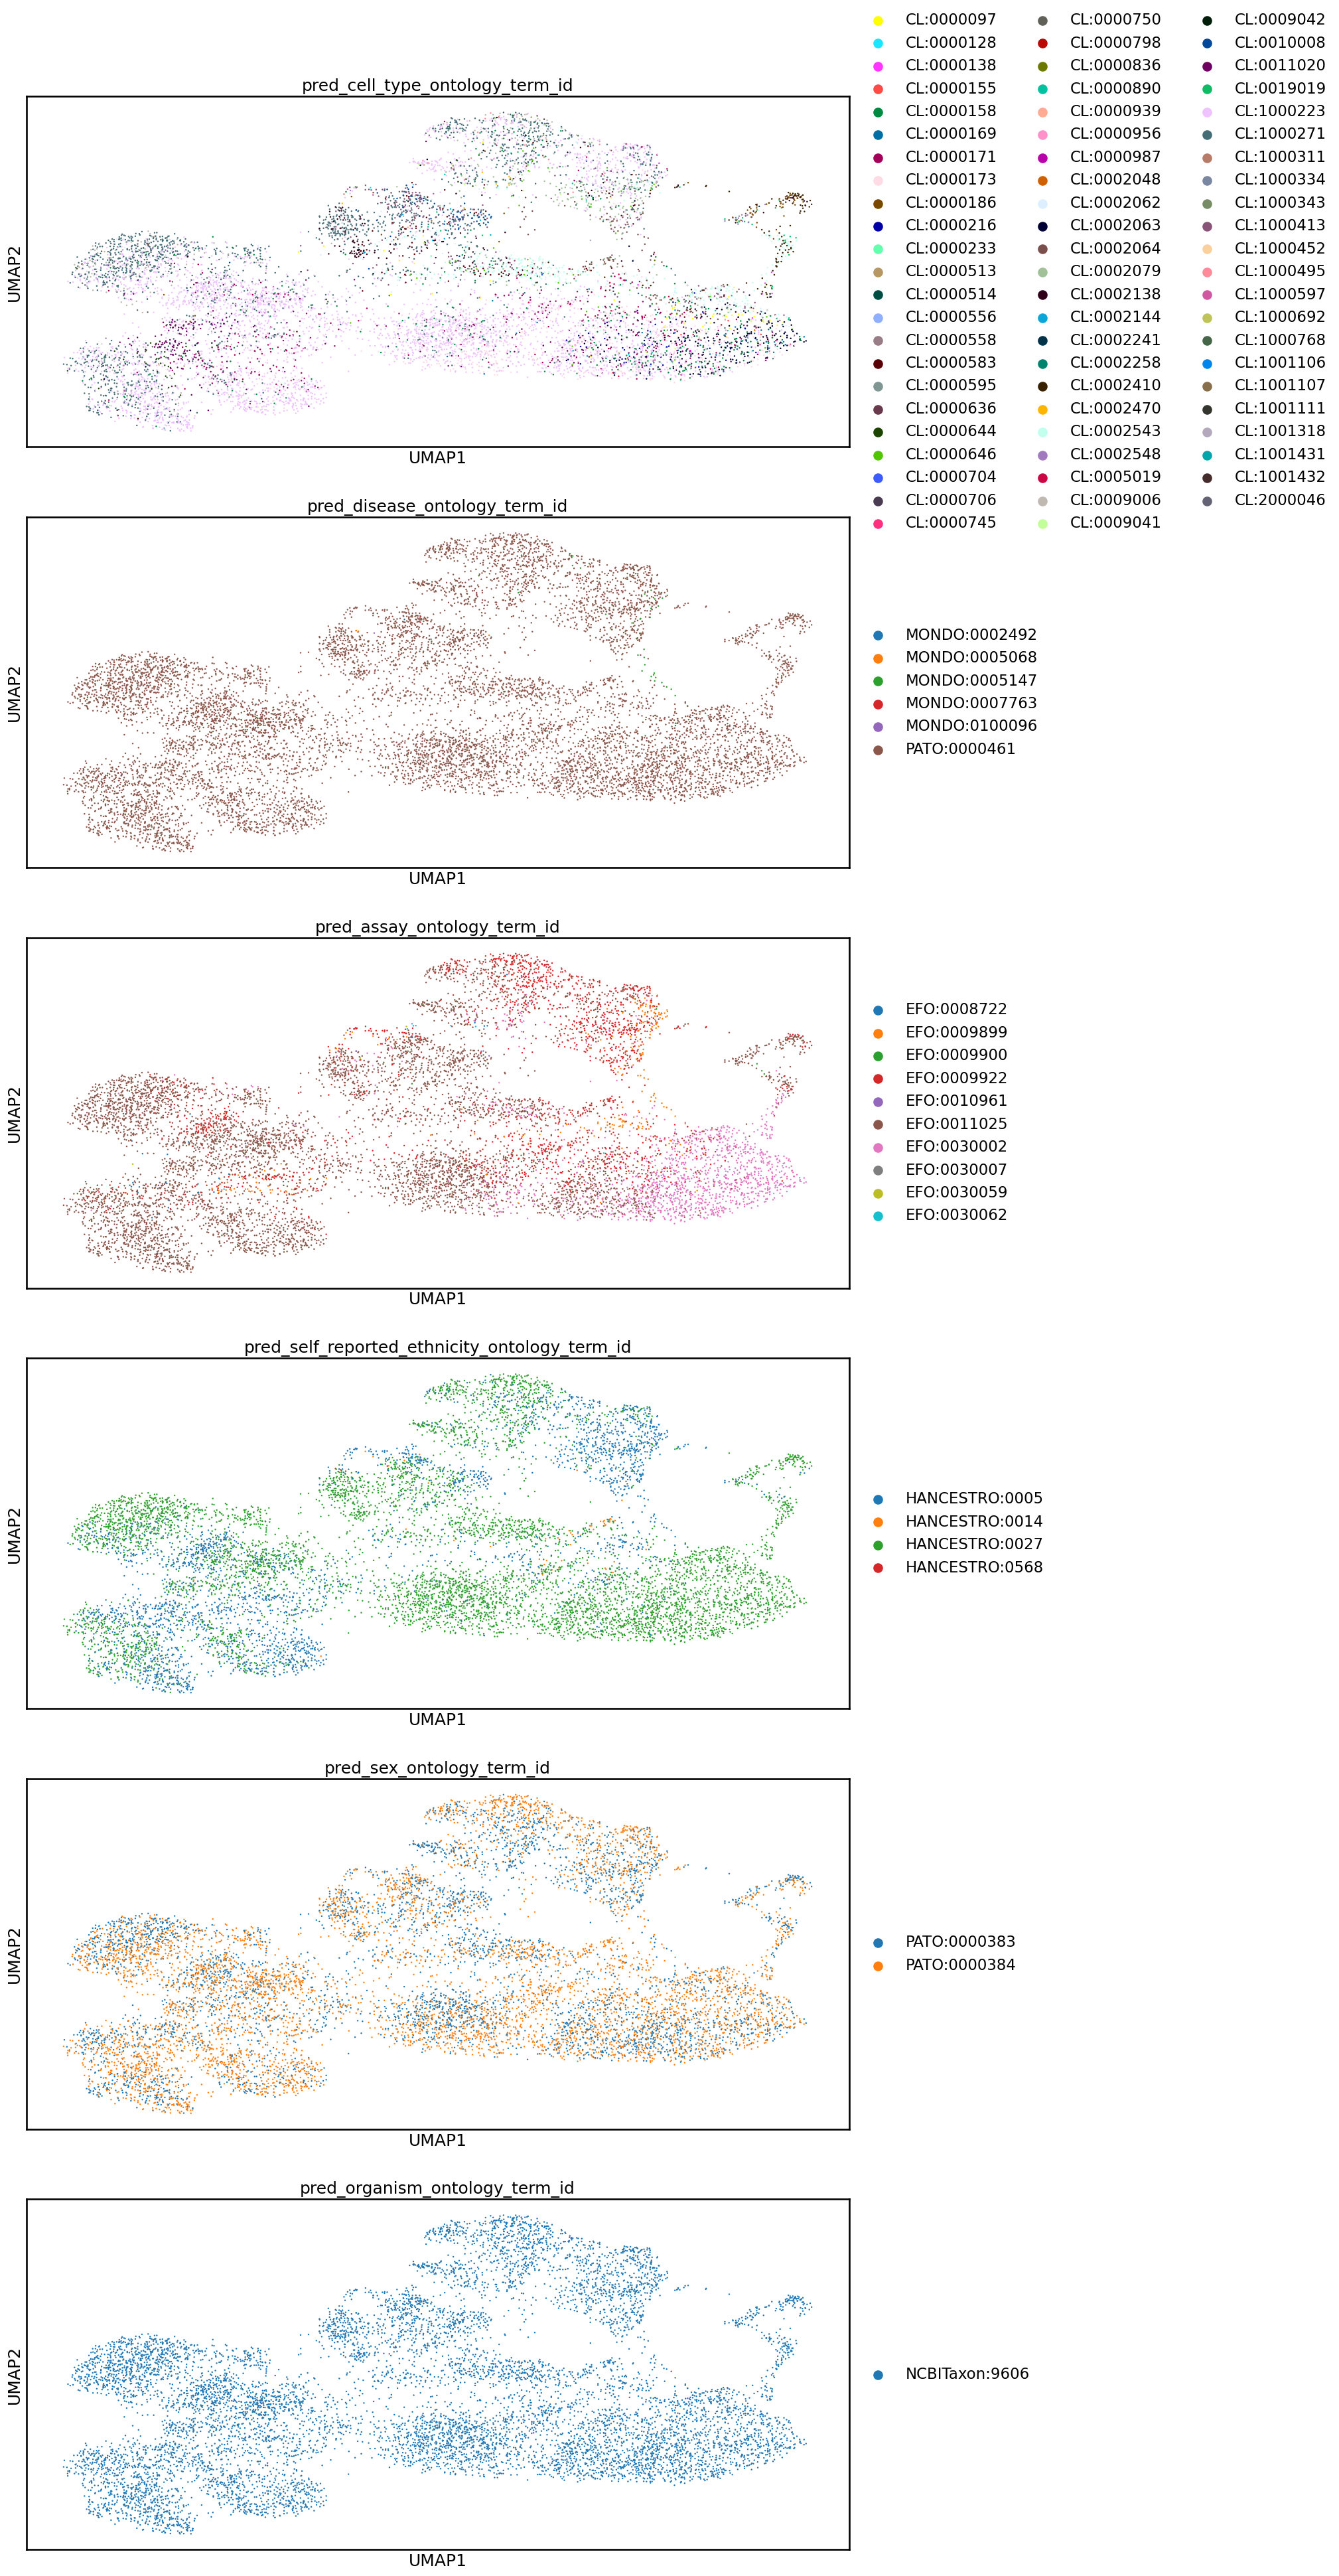

In [16]:
predictions = trainer.predict(model, dataloader)

In [157]:
expr = np.array(model.expr_pred[0])

expr[np.random.binomial(1, p=np.array(torch.nn.functional.sigmoid(model.expr_pred[2].to(torch.float32)))).astype(bool)] = 0

expr[expr<=0.5] = 0
expr[(expr<=1) & (expr>0.5)] = 1

In [153]:
pred_adata.obs

,pred_cell_type_ontology_term_id,pred_disease_ontology_term_id,pred_assay_ontology_term_id,pred_self_reported_ethnicity_ontology_term_id,pred_sex_ontology_term_id,pred_organism_ontology_term_id,leiden
0,CL:1000271,PATO:0000461,EFO:0009922,HANCESTRO:0005,PATO:0000383,NCBITaxon:9606,4
1,CL:1000223,PATO:0000461,EFO:0009922,HANCESTRO:0005,PATO:0000384,NCBITaxon:9606,4
2,CL:1000223,PATO:0000461,EFO:0009922,HANCESTRO:0005,PATO:0000384,NCBITaxon:9606,4
3,CL:1000223,PATO:0000461,EFO:0009922,HANCESTRO:0005,PATO:0000384,NCBITaxon:9606,4
4,CL:1000223,PATO:0000461,EFO:0011025,HANCESTRO:0027,PATO:0000383,NCBITaxon:9606,5
...,...,...,...,...,...,...,...
315,CL:0009006,PATO:0000461,EFO:0011025,HANCESTRO:0005,PATO:0000384,NCBITaxon:9606,2
316,CL:0000750,PATO:0000461,EFO:0011025,HANCESTRO:0005,PATO:0000384,NCBITaxon:9606,0
317,CL:0000644,PATO:0000461,EFO:0011025,HANCESTRO:0005,PATO:0000384,NCBITaxon:9606,2
318,CL:0009006,PATO:0000461,EFO:0011025,HANCESTRO:0005,PATO:0000384,NCBITaxon:9606,0


In [ ]:
pred_adata = sc.read_h5ad(
    (model.logger.save_dir if model.logger is not None else ".")
    + "/step_"
    + str(model.global_step)
    + "_umap_"
    + ".h5ad"
)

In [14]:
pred_adata

AnnData object with n_obs × n_vars = 10016 × 128
    obs: 'pred_cell_type_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'leiden'
    uns: 'leiden', 'neighbors', 'pred_assay_ontology_term_id_colors', 'pred_cell_type_ontology_term_id_colors', 'pred_disease_ontology_term_id_colors', 'pred_organism_ontology_term_id_colors', 'pred_self_reported_ethnicity_ontology_term_id_colors', 'pred_sex_ontology_term_id_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

In [15]:
adata

AnnData object with n_obs × n_vars = 16382 × 70116
    obs: 'tech', 'celltype', 'size_factors', 'organism_ontology_term_id'
    var: 'symbol', 'ncbi_gene_id', 'biotype', 'description', 'synonyms', 'mt', 'ribo', 'hb', 'organism'
    uns: 'unseen_genes'

In [16]:
subadata = adata[:10016]

In [17]:
sc.pp.pca(subadata)

In [19]:
pred_adata.obs.index = subadata.obs.index
subadata.obsm["Unintegrated"] = subadata.obsm["X_pca"]
subadata.obsm["X_umap"] = pred_adata.obsm["X_umap"]
subadata.obsm["scprint"] = pred_adata.X
pred_adata.obs.index = subadata.obs.index
subadata.obs = pd.concat([subadata.obs, pred_adata.obs], axis=1)


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:487: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


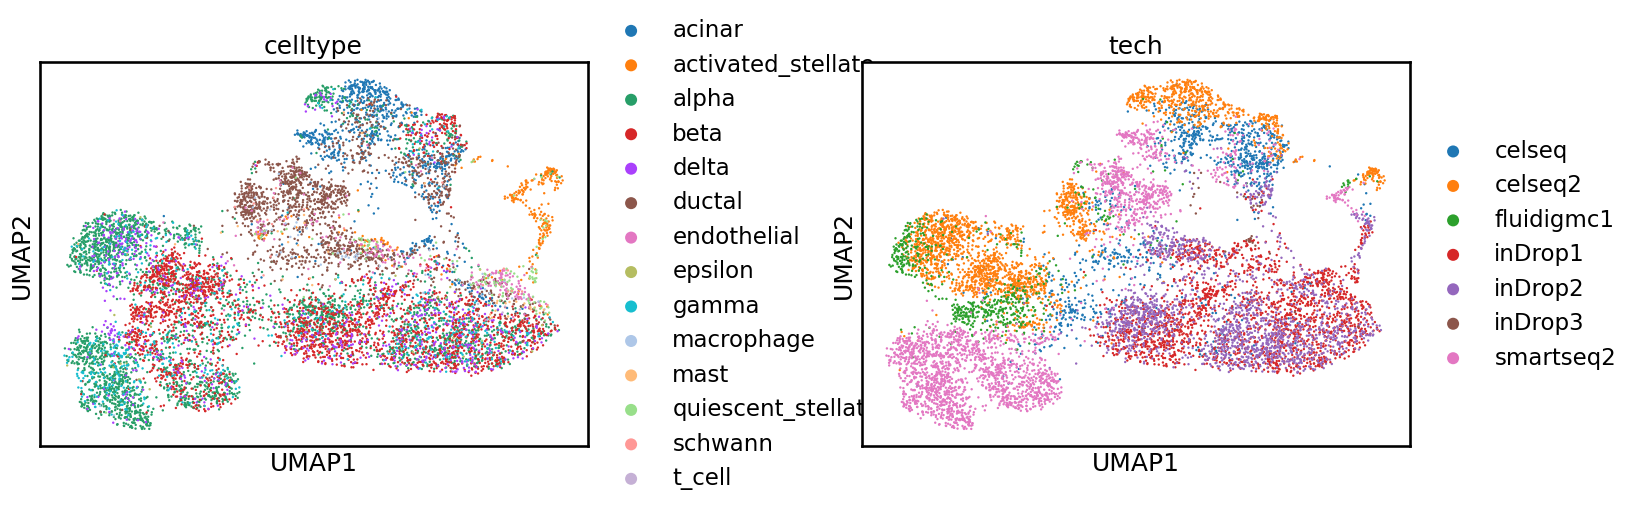

In [26]:
sc.pl.scatter(subadata, basis="umap", color=["celltype", "tech"])

In [20]:
bm = Benchmarker(
    subadata,
    batch_key="tech",
    label_key="celltype",
    embedding_obsm_keys=["Unintegrated", "scprint"],
    n_jobs=6,
)
bm.benchmark()

Metrics:   0%|          | 0/10 [00:00<?, ?it/s, Bio conservation: isolated_labels]2024-02-08 18:42:13,593:INFO - isolated labels: no more than 2 batches per label
2024-02-08 18:42:13,639:INFO - Unable to initialize backend 'cuda': 
2024-02-08 18:42:13,640:INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-02-08 18:42:13,646:INFO - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2024-02-08 18:42:13,647:WARNING - An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.

Metrics:  60%|██████    | 6/10 [00:34<00:18,  4.67s/it, Batch correction: kbet_per_label]

INFO     t_cell consists of a single batch or is too small. Skip.                                                  



Metrics:   0%|          | 0/10 [00:00<?, ?it/s]
                                                                                         
Metrics:   0%|          | 0/10 [00:00<?, ?it/s, Bio conservation: isolated_labels]2024-02-08 18:43:01,093:INFO - isolated labels: no more than 2 batches per label

Metrics:  60%|██████    | 6/10 [00:38<00:16,  4.05s/it, Batch correction: kbet_per_label]

INFO     t_cell consists of a single batch or is too small. Skip.                                                  



Embeddings: 100%|██████ | 9/10 [00:50<00:03,  3.41s/it, Batch correction: pcr_comparison]██████████| 2/2 [01:37<00:00, 49.14s/it]██████████| 2/2 [01:37<00:00, 48.89s/it]

                                                                                         

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


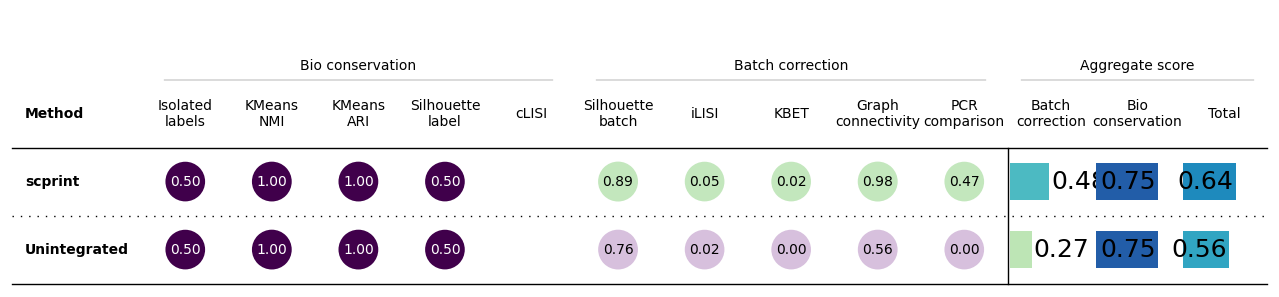

In [180]:
bm.plot_results_table(min_max_scale=False)

In [106]:
i["x"].mean()

tensor(4.4559)

In [107]:
expr[:32].mean(), expr[:32].max(), (expr[:32]==0).sum()

(11.129551, 2882.04)

In [161]:
expr[:32].mean(), expr[:32].max(), (expr[:32]==0).sum()

(6.1299295, 2174.4126, 2944)

In [162]:
i['x'].mean(), i['x'].max(), (i['x']==0).sum()

(tensor(4.4607), tensor(1597.0111), tensor(6153))

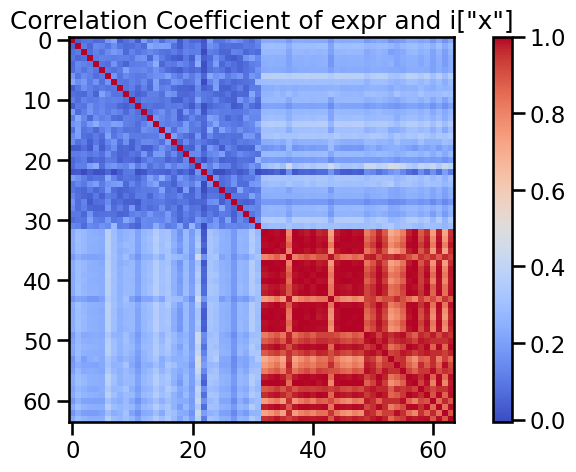

In [160]:
import matplotlib.pyplot as plt
import numpy as np

# Compute correlation coefficient
corr_coef = np.corrcoef(expr[:32].astype(int), i['x'])

# Plot correlation coefficient
plt.figure(figsize=(10, 5))
plt.imshow(corr_coef, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.title('Correlation Coefficient of expr and i["x"]')
plt.show()


In [ ]:
adata.X.iloc[0].to_array()

In [ ]:
model

## results from running it on most famous methods

![](https://scib-metrics.readthedocs.io/en/stable/_images/72bdb33d77de77ce505e24fef1d700c2b91985b1d3fcce1c2b1dd7a35c8a647f.png)

In [ ]:
## load a random dataset

In [ ]:
## do scGPT finetuning task (reusing the helper functions I have) and the notebook that they provide

In [ ]:
## create a task/function for scPrint

In [ ]:
## try to do an embedding from the regulon / single cell type matrix outputted by scenic

In [ ]:
## push it to a function on BenGRN